In [1]:
import time
import os
import cv2 as cv
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, BatchNormalization, Conv2D, Conv2DTranspose, ReLU, LeakyReLU, Flatten, MaxPooling2D, Dropout, Reshape

2024-04-25 11:11:15.254585: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 11:11:15.877177: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-25 11:11:17.902669: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/student/anaconda3/envs/tensorflow/lib/python3.10/site-packages/cv2/../../lib64:/h

### Data

In [2]:
dataset_path = 'Dataset/'

In [3]:
knee_images = len(os.listdir(os.path.join(dataset_path, '4')))
print("Number of images:", knee_images)

Number of images: 536


In [4]:
label = ['4']
count = [knee_images]

In [5]:
image_path = os.path.join(dataset_path, "4")

image_files = os.listdir(image_path)

In [6]:
# fig, axes = plt.subplots(3, 3, figsize=(10, 10))
# fig.suptitle('Normal Images', fontsize=16)
# axes = axes.ravel()

# for i, img_file in enumerate(image_files[:9]):
#     image_path = os.path.join(image_path, img_file)
#     image = cv2.imread(image_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     axes[i].imshow(image)
#     axes[i].axis('off')

# plt.tight_layout()
# plt.show()

### MODEL

In [7]:
BUFFER_SIZE = 64000
BATCH_SIZE = 32
batch_size = BATCH_SIZE
EPOCHS = 60
latent_dim = 128
input_size = [256*2, 256*2, 3]
image_size = (256*2, 256*2)

In [8]:
datagen = ImageDataGenerator(
    rescale=1./255   
)

dataset_normal= datagen.flow_from_directory(
    os.path.join(dataset_path),  
    classes=['4'],
    target_size=image_size,        
    batch_size=BATCH_SIZE,      
    class_mode='binary',        
    shuffle=True                 
)

Found 536 images belonging to 1 classes.


In [9]:
def gen_model():
    model = Sequential([
        Input(shape=(latent_dim,)),
        Dense(8 * 8 * 256),
        Reshape((8, 8, 256)),
        Conv2DTranspose(28, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.1),
        Conv2DTranspose(28, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.1),
        Conv2DTranspose(28, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.1),
        Conv2DTranspose(28, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.1),
        Conv2DTranspose(28, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.1),
        Conv2DTranspose(28, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.1),
        Conv2D(3, kernel_size=4, padding='same', activation='sigmoid')
    ],
        name="generator"
    )
    return model

def disc_model():
    model = Sequential([
        Input(shape=input_size),
        Conv2D(28, kernel_size=4, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(strides=2),
        Conv2D(28, kernel_size=4, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(strides=2),
        Conv2D(28, kernel_size=4, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(strides=2),
        Conv2D(28, kernel_size=4, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(strides=2),

        Flatten(),
        Dense(28),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ],
        name="discriminator"
    )
    return model

generator = gen_model()
generator.summary()

discriminator = disc_model()
discriminator.summary()

class Gan(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
    
    def compile(self, disc_opt, gen_opt, loss_function):
        super().compile()
        self.disc_opt = disc_opt
        self.gen_opt = gen_opt
        self.loss_function = loss_function
        self.disc_loss_metric = tf.keras.metrics.Mean(name="disc_loss")
        self.gen_loss_metric = tf.keras.metrics.Mean(name="gen_loss")
        
    @property
    def metrics(self):
        return [self.disc_loss_metric, self.gen_loss_metric]
    
    def train_step(self, data):
        real_images, real_labels = data  # Accept labels separately

        # Generate random latent vectors
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Generate fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine real and fake images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Concatenate the real and fake labels
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Discriminator training
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            disc_loss = self.loss_function(labels, predictions)

        grads = tape.gradient(disc_loss, self.discriminator.trainable_weights)
        self.disc_opt.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Generator training
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            gen_loss = self.loss_function(misleading_labels, predictions)

        grads = tape.gradient(gen_loss, self.generator.trainable_weights)
        self.gen_opt.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update loss metrics
        self.disc_loss_metric.update_state(disc_loss)
        self.gen_loss_metric.update_state(gen_loss)

        return {
            "disc_loss": self.disc_loss_metric.result(),
            "gen_loss": self.gen_loss_metric.result()
        }
    
def gen_images(generator, current_epoch, num_of_samples=2):
    noise = tf.random.normal([num_of_samples, latent_dim], dtype=tf.float32)
    generated_images = generator(noise, training=False)
    
    figure = plt.figure(figsize=(20, 20))
    for i in range(generated_images.shape[0]):
        plt.subplot(2, 2, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.title(f"After epoch {current_epoch}")
        plt.axis('off')

    plt.savefig(f'After_epochs_{current_epoch:04d}.png')
    plt.show()

class Gan_Callback(tf.keras.callbacks.Callback):
    def __init__(self, num_images=2, latent_dim=128):
        self.num_images = num_images
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        latent_vectors = tf.random.normal(shape=(self.num_images, self.latent_dim))
        generated_images = self.model.generator(latent_vectors)
        generated_images *= 255
        generated_images = generated_images.numpy()  # Removed redundant line

        figure = plt.figure(figsize=(10, 10))
        for i in range(generated_images.shape[0]):
            plt.subplot(2, 2, i + 1)
            plt.imshow(generated_images[i, :, :, 0], cmap='gray')
            plt.title(f"After epoch {epoch + 1}")
            plt.axis('off')

        plt.savefig('After_epochs_{:04d}.png'.format(epoch + 1))
        plt.show()

        if epoch % 10 == 0:
            self.model.generator.save('Saved_Models/gen.h5')
            self.model.discriminator.save('Saved_Models/disc.h5')

gan = Gan(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
disc_opt=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), 
gen_opt=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
# Parallel gpu computing won't work unless  we pass reduction=tf.keras.losses.Reduction.NONE as a parameter too.
loss_function=tf.keras.losses.BinaryCrossentropy())

2024-04-25 11:11:26.800507: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-25 11:11:26.891567: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-25 11:11:26.891701: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-25 11:11:26.895307: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them i

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             2113536   
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 28)       114716    
 nspose)                                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 28)        0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 28)       12572     
 ranspose)                                                       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 28)        0 

In [10]:
#helper funtion to help us with loadidng images in batches
def image_loader(generator):
    for images, labels in generator:
        yield images, labels

Epoch 1/60


2024-04-25 11:11:36.447521: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-25 11:11:38.014746: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-04-25 11:11:40.967405: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-25 11:11:43.729043: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fc5125b7ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-25 11:11:43.729111: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-04-25 11:11:43.763363: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-25 11:11:44.203175: I te

17/17 [==============================] - ETA: 0s - disc_loss: 0.6706 - gen_loss: 0.6282

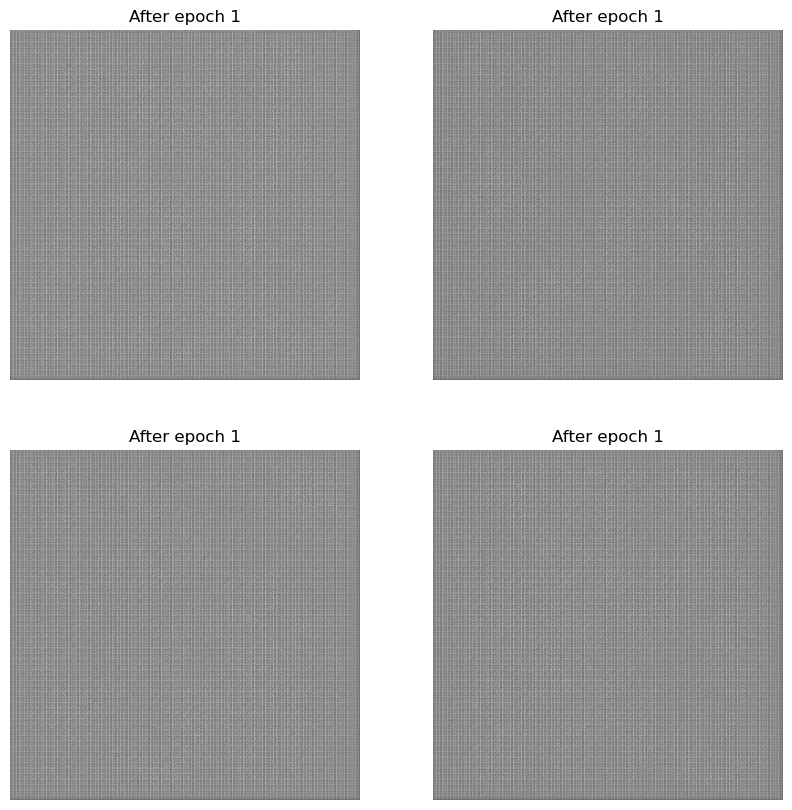

17/17 [==============================] - 28s 580ms/step - disc_loss: 0.6706 - gen_loss: 0.6282
Epoch 2/60
17/17 [==============================] - ETA: 0s - disc_loss: 0.5992 - gen_loss: 0.7446

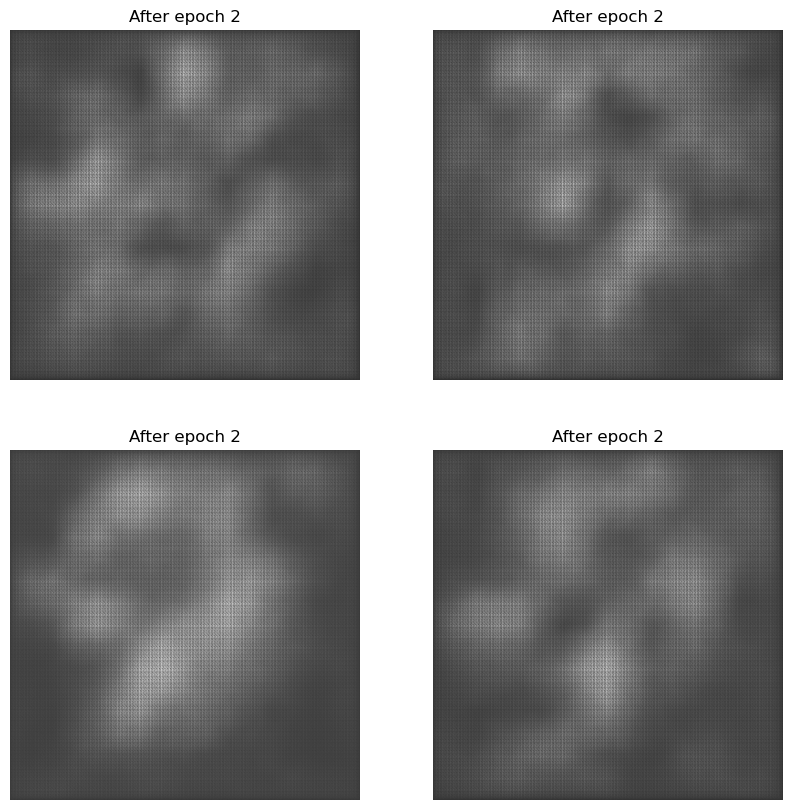

17/17 [==============================] - 8s 445ms/step - disc_loss: 0.5992 - gen_loss: 0.7446
Epoch 3/60
17/17 [==============================] - ETA: 0s - disc_loss: 0.6741 - gen_loss: 0.9011

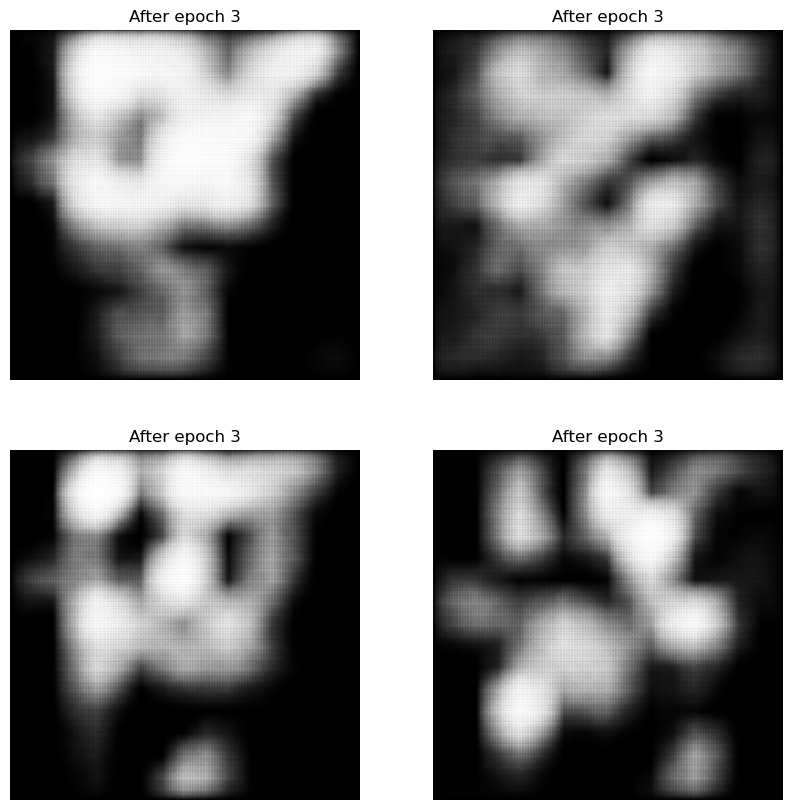

17/17 [==============================] - 7s 440ms/step - disc_loss: 0.6741 - gen_loss: 0.9011
Epoch 4/60
17/17 [==============================] - ETA: 0s - disc_loss: 0.6765 - gen_loss: 0.8667

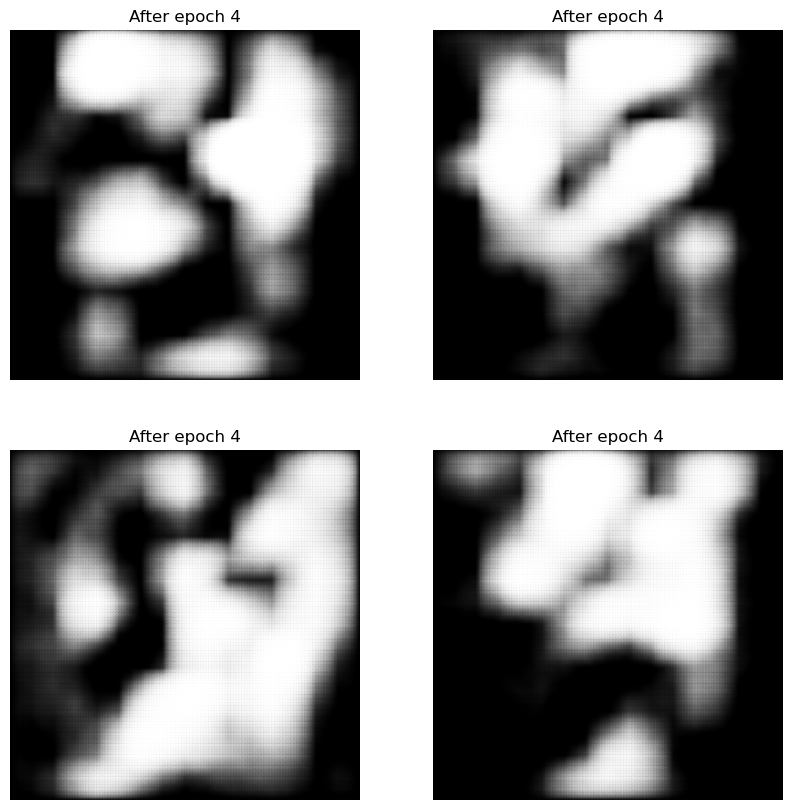

17/17 [==============================] - 7s 435ms/step - disc_loss: 0.6765 - gen_loss: 0.8667
Epoch 5/60
17/17 [==============================] - ETA: 0s - disc_loss: 0.6353 - gen_loss: 0.9772

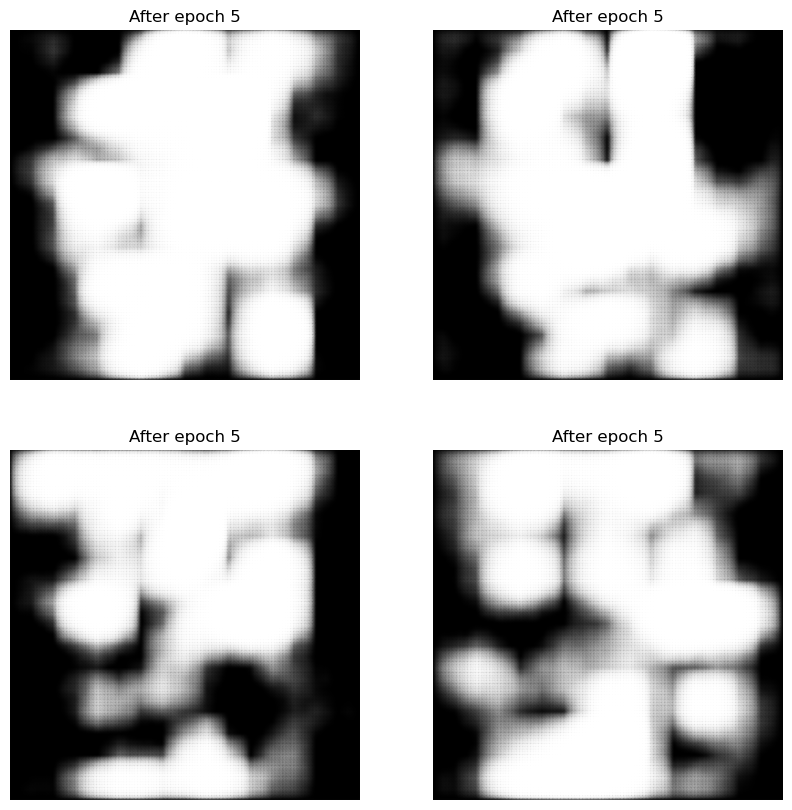

17/17 [==============================] - 7s 440ms/step - disc_loss: 0.6353 - gen_loss: 0.9772
Epoch 6/60
17/17 [==============================] - ETA: 0s - disc_loss: 0.6266 - gen_loss: 1.0252

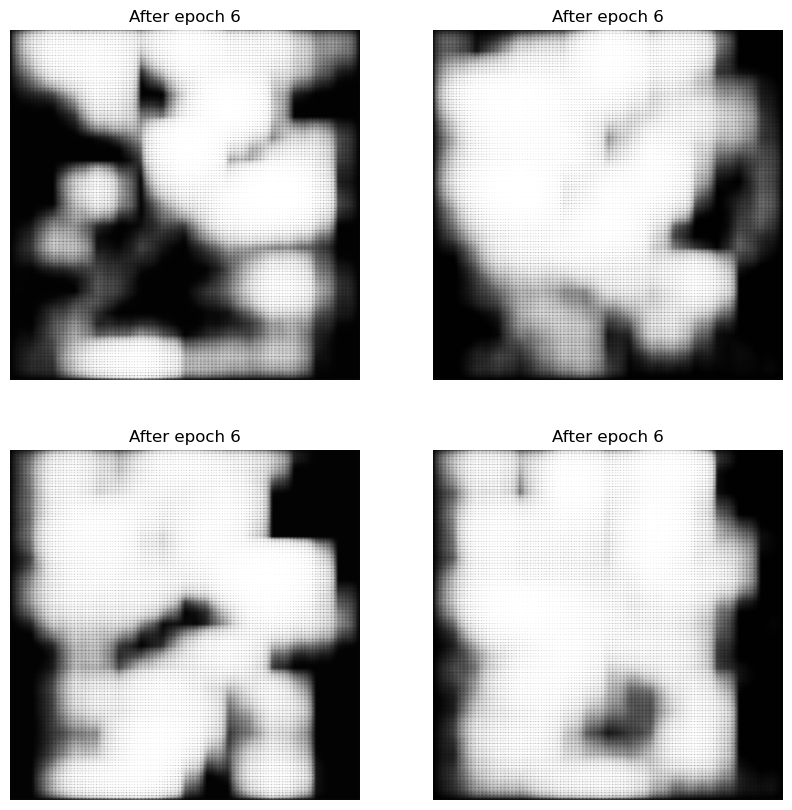

17/17 [==============================] - 8s 458ms/step - disc_loss: 0.6266 - gen_loss: 1.0252
Epoch 7/60
17/17 [==============================] - ETA: 0s - disc_loss: 0.6111 - gen_loss: 1.0529

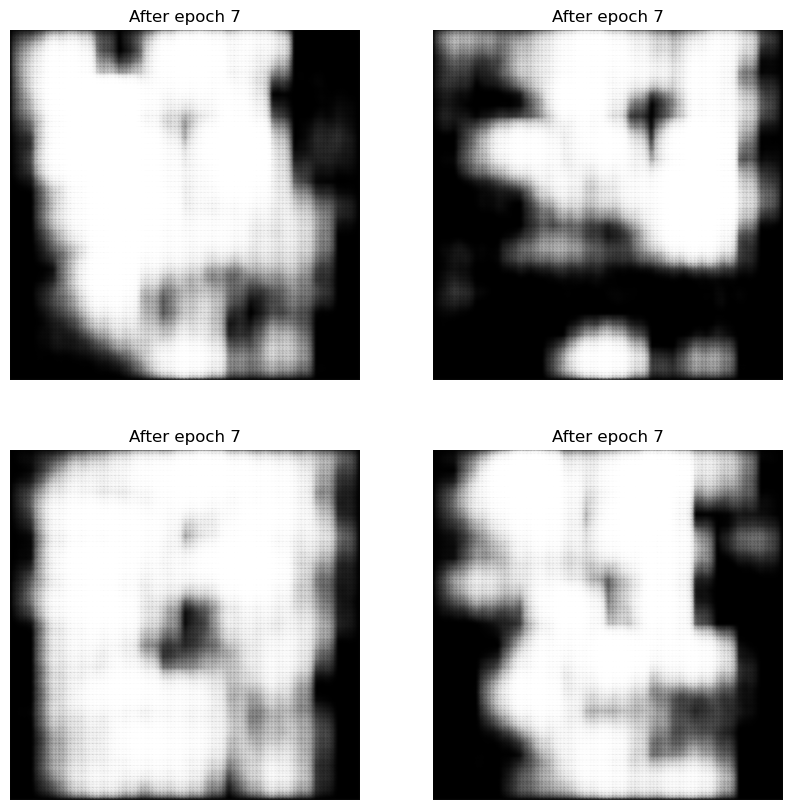

17/17 [==============================] - 8s 463ms/step - disc_loss: 0.6111 - gen_loss: 1.0529
Epoch 8/60
17/17 [==============================] - ETA: 0s - disc_loss: 0.6255 - gen_loss: 1.0019

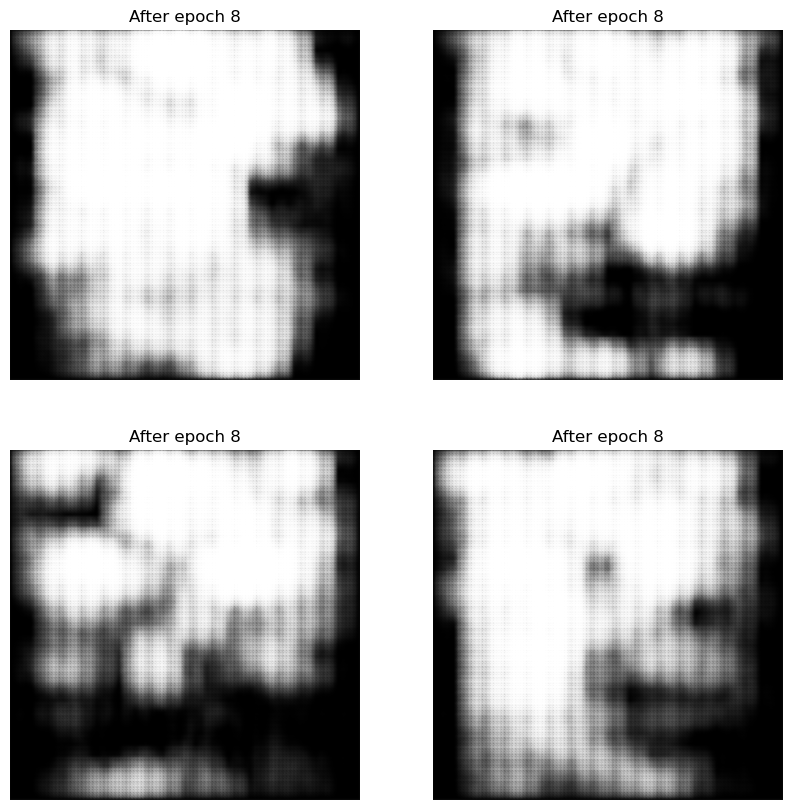

17/17 [==============================] - 8s 452ms/step - disc_loss: 0.6255 - gen_loss: 1.0019
Epoch 9/60
17/17 [==============================] - ETA: 0s - disc_loss: 0.6192 - gen_loss: 0.9873

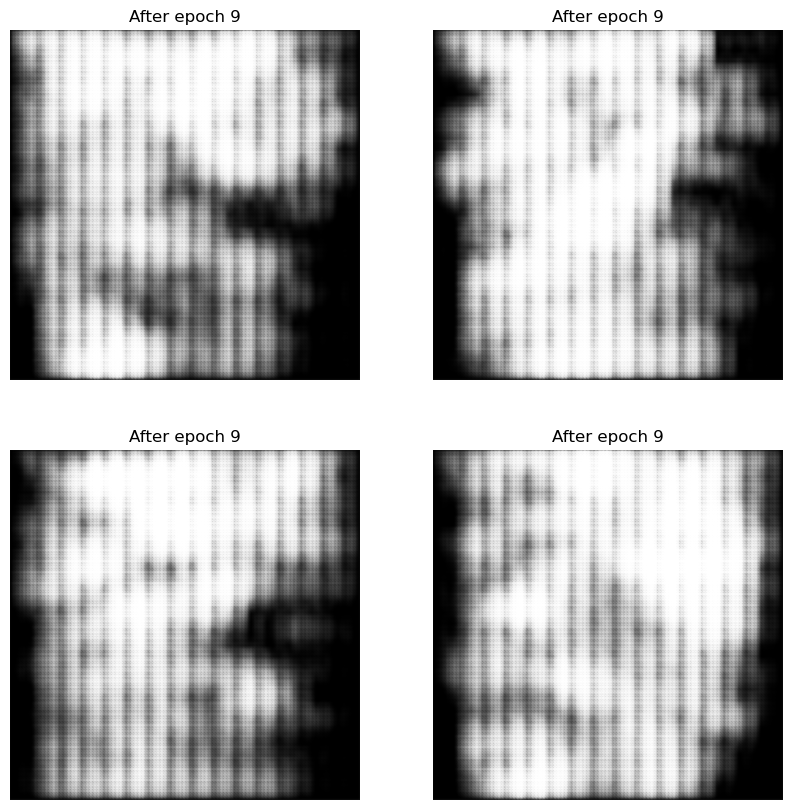

17/17 [==============================] - 8s 462ms/step - disc_loss: 0.6192 - gen_loss: 0.9873
Epoch 10/60
17/17 [==============================] - ETA: 0s - disc_loss: 0.6209 - gen_loss: 1.0021

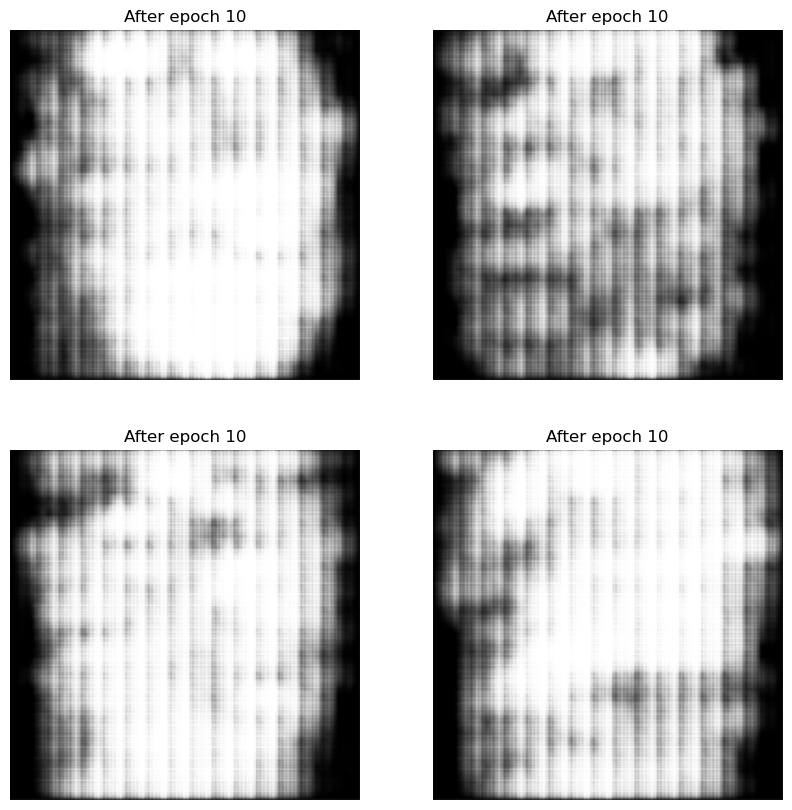

17/17 [==============================] - 8s 457ms/step - disc_loss: 0.6209 - gen_loss: 1.0021
Epoch 11/60
 9/17 [==============>...............] - ETA: 3s - disc_loss: 0.6281 - gen_loss: 1.0120

In [ ]:
#actual traing begins here
history = gan.fit(
    image_loader(dataset_normal), 
    epochs=EPOCHS,
    steps_per_epoch=len(dataset_normal),  
    callbacks=[Gan_Callback(num_images=4, latent_dim=latent_dim)]
)